# Summary
<p>
This is a time series problem. The basic of time series models require that the time series doesnot have any trend. To detrend the data , we can either decompose the signal using algorithms like LOESS decomposition or we can difference the data. I used differencing in this case to make the time series stationary. After differencing all the columns became stationary. I confirmed stationarity with ADF Test . 
</p>
<p>AR , MA models are basic time series models and next comes ARMA models. If we difference the data to make it stationary , the models that difference and use ARMA models are called ARIMA models. The models which have Seasonal Component in them on top of ARIMA are called Seasonal ARIMA or SARIMA. To remove seasonal component we can just see what is the seasonality and do the many lags difference. SARIMA is the most general case univariate modelling noise/stochastic model. 
</p>
<p>But in this problem , we have Signals also. We can extract information from Signals also for modelling Price. There are two things - (1) Which Signals are relevant (which is found by Granger Causality test) and (2) how much they affect the modelling of Price. As mentioned in brackets , I used Granger Causality Test to conclude that Signals 1,2,4 and 7 Granger-Causes Price. Now coming to how much they affect , I will tell about ARMA models and continue from there on how to use info from relevant signals to model price. ARMA models are made of AR component and MA component.</p>
<p> AR means Auto regressive i.e Present price value depends on past price value. Price(t) = theta1 * Price(t-1) + theta2 * Price(t-2) + .... + 
thetap * Price(t-p) + epsilon( Gaussian Noise). MV is Moving average which tells that if A noise caused Price(t-2) , it will also have component in Price(t-1) , Price(t) ,... with different coefficients. In MV , Price is modelled as Price(t) = psi1 * Gauss1 + psi2 * Gauss2 + ... psiq * Gaussq. Combining both AR and MA is called ARMA model. Now how to find p and q. Those can be found from ACF and PACF plots. The furtherest spike above +- 1.96/sqrt(n) gives p in ACF and q in PACF. I also found that in lag 15, both ACF and PACF had spikes. So I concluded that 15 is the seasonality - which is 3 weeks (5 trading days in a week) - seems reasonable. From ACF and PACF plots , I was not sure whether to pick 1 or 2 for both p and q as in both cases the spike in lag 2 is very close the threshold line. So I used auto_arima from pmadrima package and it gave me p=1 and q=1 - which goes well with inference from the plots also. So after differencing the Price can unvariate-modelled as ARMA(1,1). I used ARIMA model from pmdarima package and tried to model the price. But it was no-where close. Thats where the signals come into picture.</p>
<p> Just how we found p and q from ACF and PACF plots, we can see cross-covariance between the Residual ( Differenced Price - ARMA(1,1) ) and the Signals one by one. We will see spikes in the cross-covariance plot which will tell us that Price(t) is affected by Signal(t - {some_lag} ). Now what is the coefficient to give to the signal? Coefficient = sqrt(Var(Price Residual)/Var(Signal)) because mean is anyway zero due to stationarity and what makes the signal/Price go up and down is the variance. So I started searching on how to implement this when I found that there is something called SARIMAX in pmdarima where the X is for exogenous or other signals which is the case for us. So I used the model and gave exogenous as Signals 1,2,4 and 7. I got the output very very similar to original Price. </p>
<p>
I saw there are other models also Like LSTM RNN and Facebook Prophet. I tried LSTM RNN but I just got a flat line. I also read the book "Hands-on Time Series Analysis With Python (2020)". Even in this book SARIMA model gave the best result and there were not good results with Deep Learning Models. So I ended my exploration , concluding that SARIMAX is the answer to this problem. </p>
<p>
To confirm that there are not any other models that can solve this problem , I read the book "Introduction to Time Series and Forecasting". The models after SARIMA that they cover are VAR and State Space. I dont think that can be used here because in those, it is assumed that Price also cause the Signals to change which is not the case here. So after reading this Springer book , I again concluded that SARIMAX is the best that can be done.</p>
P.S. For some reason the plots sometimes disappear. Please rerun those cells.

# Importing Libraries and reading csv file

In [1]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import pmdarima


Please install these packages and nbformat >= 4.2.0

In [2]:
df = pd.read_csv('quant_dataset.csv')

# Preprocessing and Data Exploration

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.drop(df.columns[[0]], axis=1, inplace=True)
df.sort_values('Date', inplace=True)
for column in df:
    df[column] = df[column].fillna(method='ffill')

In [4]:
df.head()

Date   Price  Signal1  Signal2   Signal3   Signal4  Signal5  \
2999 2005-01-03  1202.1   1384.1  1200.69  1646.550  1411.759  763.971   
2998 2005-01-04  1188.0   1378.0  1207.17  1641.369  1422.754  764.928   
2997 2005-01-05  1183.7   1381.7  1206.00  1641.089  1425.334  765.886   
2996 2005-01-06  1187.9   1377.9  1210.32  1641.057  1425.951  765.614   
2995 2005-01-07  1186.2   1384.2  1217.52  1642.076  1437.734  766.572   

      Signal6   Signal7  
2999    232.8  2976.796  
2998    248.8  2989.034  
2997    248.8  2993.712  
2996    248.8  2985.111  
2995    264.8  2983.811

In [5]:
df = df.set_index("Date")
df

Price  Signal1   Signal2   Signal3   Signal4   Signal5  Signal6  \
Date                                                                            
2005-01-03  1202.10  1384.10  1200.690  1646.550  1411.759   763.971    232.8   
2005-01-04  1188.00  1378.00  1207.170  1641.369  1422.754   764.928    248.8   
2005-01-05  1183.70  1381.70  1206.000  1641.089  1425.334   765.886    248.8   
2005-01-06  1187.90  1377.90  1210.320  1641.057  1425.951   765.614    248.8   
2005-01-07  1186.20  1384.20  1217.520  1642.076  1437.734   766.572    264.8   
...             ...      ...       ...       ...       ...       ...      ...   
2016-11-23  2204.72  1610.72  1719.306  1225.037  1025.879  1481.172   2904.8   
2016-11-25  2213.35  1627.35  1718.271  1228.255  1028.893  1484.897   2920.8   
2016-11-28  2201.72  1623.72  1746.585  1228.043  1054.482  1488.624   2904.8   
2016-11-29  2204.66  1618.66  1754.199  1226.297  1056.146  1485.327   2888.8   
2016-11-30  2198.81  1604.81  1747.755  1223.065  1046.997  1482.027   2888.8   

             Signal7  
Date                  
2005-01-03  2976.796  
2005-01-04  2989.034  
2005-01-05  2993.712  
2005-01-06  2985.111  
2005-01-07  2983.811  
...              ...  
2016-11-23  5168.150  
2016-11-25  5168.596  
2016-11-28  5159.236  
2016-11-29  5146.420  
2016-11-30  5157.211  

[3000 rows x 8 columns]

In [6]:
for column in df:
    print(column)
    fig = px.line(df, y=df[column])
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

Price


Signal1


Signal2


Signal3


Signal4


Signal5


Signal6


Signal7


Price Increases , Decreases and again Incrases. There is a trend. So need to use differencing to make series stationary.

# Stationarity Tests

- Null Hypothesis -  Series possesses a unit root and hence not stationary
- Alternate Hypothesis - Series is stationary

Augmented Dickey Fuller Test for Stationarity

In [7]:
for column in df:
    result = adfuller (df [column])
    print (f'Test Statistics: {result [0]}')
    print(f'p-value: {result [1]}')
    print(f'Critial Values: {result [4]}')
    if result [1] > 0.05 :
        print(column + ' Series is not Stationary')
    else:
        print(column + ' Series is Stationary')
    print("")

Test Statistics: -0.07409962398313319
p-value: 0.9519579812602793
Critial Values: {'1%': -3.432547027098869, '5%': -2.8625107035227066, '10%': -2.5672867314313095}
Price Series is not Stationary

Test Statistics: -1.4362145829433903
p-value: 0.56479659468213
Critial Values: {'1%': -3.432536010490222, '5%': -2.8625058378852355, '10%': -2.5672841410186216}
Signal1 Series is not Stationary

Test Statistics: -0.6415564469632334
p-value: 0.8613128370316514
Critial Values: {'1%': -3.4325440784940295, '5%': -2.8625094012323866, '10%': -2.5672860381057525}
Signal2 Series is not Stationary

Test Statistics: -1.1225696651956285
p-value: 0.705987981979954
Critial Values: {'1%': -3.432545551806462, '5%': -2.8625100519404665, '10%': -2.5672863845358074}
Signal3 Series is not Stationary

Test Statistics: -1.7775655028602375
p-value: 0.3916552970970936
Critial Values: {'1%': -3.4325330913621452, '5%': -2.862504548608965, '10%': -2.5672834546224057}
Signal4 Series is not Stationary

Test Statistics: -

None of the time series is Stationary

Differencing

In [8]:
dfDiff = df.diff().dropna()
dfDiff

Price  Signal1  Signal2  Signal3  Signal4  Signal5  Signal6  \
Date                                                                      
2005-01-04 -14.10    -6.10    6.480   -5.181   10.995    0.957     16.0   
2005-01-05  -4.30     3.70   -1.170   -0.280    2.580    0.958      0.0   
2005-01-06   4.20    -3.80    4.320   -0.032    0.617   -0.272      0.0   
2005-01-07  -1.70     6.30    7.200    1.019   11.783    0.958     16.0   
2005-01-10   4.00    12.00   -2.070    3.867    1.590    0.960      0.0   
...           ...      ...      ...      ...      ...      ...      ...   
2016-11-23   1.78     9.78   21.303    2.058   20.204    3.721    -16.0   
2016-11-25   8.63    16.63   -1.035    3.218    3.014    3.725     16.0   
2016-11-28 -11.63    -3.63   28.314   -0.212   25.589    3.727    -16.0   
2016-11-29   2.94    -5.06    7.614   -1.746    1.664   -3.297    -16.0   
2016-11-30  -5.85   -13.85   -6.444   -3.232   -9.149   -3.300      0.0   

            Signal7  
Date                 
2005-01-04   12.238  
2005-01-05    4.678  
2005-01-06   -8.601  
2005-01-07   -1.300  
2005-01-10   -2.182  
...             ...  
2016-11-23  -20.392  
2016-11-25    0.446  
2016-11-28   -9.360  
2016-11-29  -12.816  
2016-11-30   10.791  

[2999 rows x 8 columns]

In [9]:
for column in dfDiff:
    print(column)
    fig = px.line(dfDiff, y=dfDiff[column])
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

Price


Signal1


Signal2


Signal3


Signal4


Signal5


Signal6


Signal7


Augmented Dickey Fuller Test

In [10]:
for column in dfDiff:
    result = adfuller (dfDiff [column])
    print (f'Test Statistics: {result [0]}')
    print(f'p-value: {result [1]}')
    print(f'Critial Values: {result [4]}')
    if result [1] > 0.05 :
        print(column + ' Series is not Stationary')
    else:
        print(column + ' Series is Stationary')
    print("")

Test Statistics: -12.208671424988601
p-value: 1.177450073623296e-22
Critial Values: {'1%': -3.432547027098869, '5%': -2.8625107035227066, '10%': -2.5672867314313095}
Price Series is Stationary

Test Statistics: -25.96925236844183
p-value: 0.0
Critial Values: {'1%': -3.432536010490222, '5%': -2.8625058378852355, '10%': -2.5672841410186216}
Signal1 Series is Stationary

Test Statistics: -13.673303517267193
p-value: 1.4459545893246668e-25
Critial Values: {'1%': -3.4325440784940295, '5%': -2.8625094012323866, '10%': -2.5672860381057525}
Signal2 Series is Stationary

Test Statistics: -13.577982795144544
p-value: 2.1510548968744897e-25
Critial Values: {'1%': -3.432545551806462, '5%': -2.8625100519404665, '10%': -2.5672863845358074}
Signal3 Series is Stationary

Test Statistics: -57.986700798958445
p-value: 0.0
Critial Values: {'1%': -3.4325330913621452, '5%': -2.862504548608965, '10%': -2.5672834546224057}
Signal4 Series is Stationary

Test Statistics: -31.471177350491676
p-value: 0.0
Critia

- All Are stationary

# Causality Tests


- We need to keep only relevant signals. 
- Apply Granger's Causality Test to find the relevant signals

Taking max_lags to be 4 weeks ie 20 days

In [11]:
max_lags = 20

In [12]:
for column in df:
    if column != 'Price':
        print(column)
        results=grangercausalitytests(df[['Price', column]], max_lags, verbose=False)
        p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
        print('p Values per lag - '+str (p_values))
        count = sum(i < 0.05 for i in p_values)
        print('Count of values < 0.05 is ' + str(count))
        #print(results)

Signal1
p Values per lag - [0.0219, 0.0398, 0.0461, 0.0525, 0.0002, 0.0001, 0.0002, 0.0005, 0.0008, 0.0013, 0.0019, 0.0015, 0.0024, 0.0028, 0.0024, 0.004, 0.0014, 0.0022, 0.0036, 0.0049]
Count of values < 0.05 is 19
Signal2
p Values per lag - [0.0092, 0.0046, 0.0117, 0.0122, 0.0009, 0.0016, 0.0026, 0.005, 0.008, 0.0119, 0.0218, 0.0123, 0.0155, 0.0214, 0.0129, 0.0213, 0.0368, 0.0533, 0.0569, 0.0772]
Count of values < 0.05 is 17
Signal3
p Values per lag - [0.0335, 0.0191, 0.0447, 0.0671, 0.0342, 0.0592, 0.0952, 0.1181, 0.1392, 0.1973, 0.0861, 0.0634, 0.0849, 0.1174, 0.1571, 0.2302, 0.2725, 0.3027, 0.1652, 0.2072]
Count of values < 0.05 is 4
Signal4
p Values per lag - [0.9827, 0.0997, 0.1808, 0.1954, 0.0006, 0.0012, 0.0024, 0.0048, 0.0046, 0.0085, 0.0155, 0.0061, 0.0086, 0.0113, 0.0084, 0.0155, 0.0262, 0.0367, 0.0361, 0.0492]
Count of values < 0.05 is 16
Signal5
p Values per lag - [0.1474, 0.1986, 0.2932, 0.4417, 0.0452, 0.0707, 0.1133, 0.1655, 0.2279, 0.2936, 0.3682, 0.0801, 0.1117, 0.14

if ftest p value < 0.05 , column granger causes Price

- Signal 1
- Signal 2
- Signal 4
- Signal 7
- Granger Causes Price

In [13]:
for column in ['Price','Signal1','Signal2','Signal4','Signal7']:
    print(column)
    fig = px.line(dfDiff, y=dfDiff[column])
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

Price


Signal1


Signal2


Signal4


Signal7


In [14]:
dfDiff.head()

Price  Signal1  Signal2  Signal3  Signal4  Signal5  Signal6  \
Date                                                                      
2005-01-04  -14.1     -6.1     6.48   -5.181   10.995    0.957     16.0   
2005-01-05   -4.3      3.7    -1.17   -0.280    2.580    0.958      0.0   
2005-01-06    4.2     -3.8     4.32   -0.032    0.617   -0.272      0.0   
2005-01-07   -1.7      6.3     7.20    1.019   11.783    0.958     16.0   
2005-01-10    4.0     12.0    -2.07    3.867    1.590    0.960      0.0   

            Signal7  
Date                 
2005-01-04   12.238  
2005-01-05    4.678  
2005-01-06   -8.601  
2005-01-07   -1.300  
2005-01-10   -2.182

In [15]:
dfImp = df[['Price','Signal1','Signal2','Signal4','Signal7']]
dfImp

Price  Signal1   Signal2   Signal4   Signal7
Date                                                      
2005-01-03  1202.10  1384.10  1200.690  1411.759  2976.796
2005-01-04  1188.00  1378.00  1207.170  1422.754  2989.034
2005-01-05  1183.70  1381.70  1206.000  1425.334  2993.712
2005-01-06  1187.90  1377.90  1210.320  1425.951  2985.111
2005-01-07  1186.20  1384.20  1217.520  1437.734  2983.811
...             ...      ...       ...       ...       ...
2016-11-23  2204.72  1610.72  1719.306  1025.879  5168.150
2016-11-25  2213.35  1627.35  1718.271  1028.893  5168.596
2016-11-28  2201.72  1623.72  1746.585  1054.482  5159.236
2016-11-29  2204.66  1618.66  1754.199  1056.146  5146.420
2016-11-30  2198.81  1604.81  1747.755  1046.997  5157.211

[3000 rows x 5 columns]

# Getting p,q and d from ACF and PACF plots

/Users/vigneshwaran_mahadevan/mambaforge/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



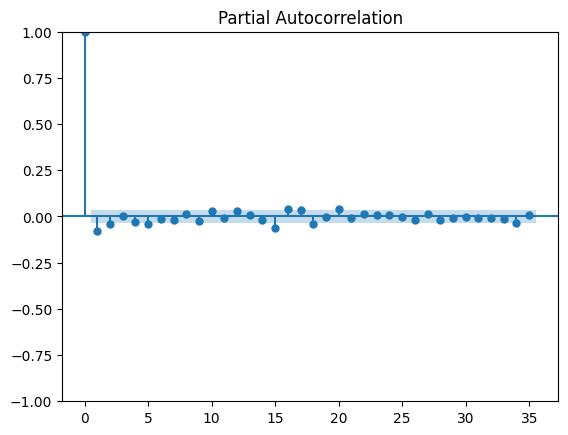

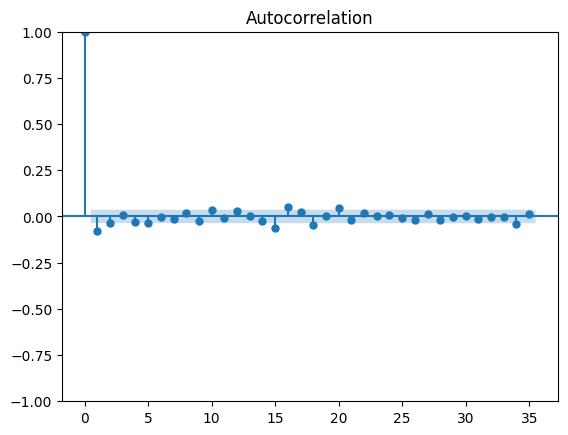

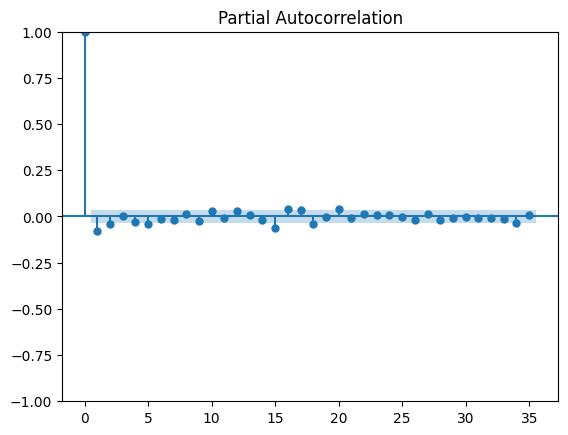

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(dfDiff["Price"])
plot_pacf(dfDiff["Price"])

* p = [1 or 2]
* q = [1 or 2]
* seasonal diff at 15 lags = 3 weeks

# Fitting SARIMAX Model

In [17]:
exogenous = dfDiff[['Signal1','Signal2','Signal4','Signal7']]

In [18]:
pmdarima.arima.auto_arima(dfDiff["Price"], exogenous = exogenous, d = 15, seasonal=True, stationary=True, n_jobs=-1,transparams=False,maxiter=50,suppress_warnings=True,return_valid_fits=True)

/Users/vigneshwaran_mahadevan/mambaforge/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



(ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 0, 2), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True))

* For the differenced Price data ARMA(1,1) is the best model with seasonality - 15

In [19]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(dfDiff["Price"], exog = exogenous, order= (1,0,1) ,seasonal_order=(0,0,0,15))
model = arima_model.fit()
print (model.summary ())


/Users/vigneshwaran_mahadevan/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/vigneshwaran_mahadevan/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/vigneshwaran_mahadevan/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 2999
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -9159.223
Date:                Tue, 17 Jan 2023   AIC                          18334.446
Time:                        20:08:23   BIC                          18382.494
Sample:                             0   HQIC                         18351.729
                               - 2999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3553      0.062      5.771      0.000       0.235       0.476
Signal1        0.5889      0.006    105.840      0.000       0.578       0.600
Signal2        0.3954      0.010     40.500      0.0

In [20]:
fig = px.line(model.fittedvalues)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

fig = px.line(dfDiff, y=dfDiff['Price'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()


The value from model is on top and Original Price is down. There are very very similar and hence modelling is completed successfully.